# SOC-ML: Threat Detection Model Training

**Author:** Brian Chaplow (Chappy McNasty)  
**Project:** HomeLab SOC v2 ML Pipeline  
**Date:** January 2026

---

## Overview

This notebook trains a supervised threat detection model using Suricata alerts from the HomeLab SOC.

**Data Sources:**
- Suricata alerts (13M+ events)
- Flow records (12.6M+ benign baseline)
- HOMELAB custom rules (attack labels from purple team)

**Approach:**
1. Extract and label data from OpenSearch
2. Engineer features from network telemetry
3. Train XGBoost classifier with proper class balancing
4. Evaluate using PR-AUC (appropriate for imbalanced data)
5. Analyze with SHAP for interpretability

In [1]:
# Standard imports
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Project imports
from src.utils.opensearch import get_client
from src.data.extract import get_extractor
from src.data.features import get_feature_engineer
from src.models.train import get_trainer

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print("Imports complete!")

Imports complete!


## 1. Test OpenSearch Connection

In [2]:
# Test connection
client = get_client()
assert client.test_connection(), "OpenSearch connection failed!"

# Check data availability
print("\nData availability:")
for event_type in ['alert', 'flow']:
    count = client.get_index_count(
        'fluentbit-default',
        {"term": {"event_type": event_type}}
    )
    print(f"  {event_type}: {count:,}")

[2026-01-27 12:05:13,121] INFO - OpenSearch client created: 10.10.20.10:9200
[2026-01-27 12:05:13,152] INFO - GET https://10.10.20.10:9200/ [status:200 request:0.030s]
[2026-01-27 12:05:13,152] INFO - Connected to OpenSearch 3.3.2
[2026-01-27 12:05:13,154] INFO - POST https://10.10.20.10:9200/fluentbit-default/_count [status:200 request:0.002s]
[2026-01-27 12:05:13,156] INFO - POST https://10.10.20.10:9200/fluentbit-default/_count [status:200 request:0.001s]



Data availability:
  alert: 13,096,666
  flow: 12,768,823


## 2. Extract Training Data

We use a **temporal split**:
- **Training:** Dec 3, 2025 - Jan 15, 2026
- **Testing:** Jan 16, 2026 - Jan 27, 2026

This simulates real-world deployment where we train on historical data and predict on future events.

In [3]:
# Initialize extractor
extractor = get_extractor()

# Extract and prepare data
# Note: This may take a few minutes depending on data volume
train_df, test_df = extractor.extract_and_prepare(
    train_start="2025-12-03",
    train_end="2026-01-15",
    test_start="2026-01-16",
    test_end="2026-01-27",
    max_alerts=500000,
    max_flows=200000,
    save=True
)

[2026-01-27 12:05:13,174] INFO - OpenSearch client created: 10.10.20.10:9200
[2026-01-27 12:05:13,174] INFO - ============================================================
[2026-01-27 12:05:13,175] INFO - SOC-ML Data Extraction Pipeline
[2026-01-27 12:05:13,175] INFO - ============================================================
[2026-01-27 12:05:13,175] INFO - 
[1/4] Extracting training alerts (2025-12-03 to 2026-01-15)...
[2026-01-27 12:05:13,176] INFO - Loading cached alerts from /home/butcher/soc-ml/src/data/../../data/raw/alerts_1312e881.parquet
[2026-01-27 12:05:13,267] INFO - 
[2/4] Extracting training flows...
[2026-01-27 12:05:13,267] INFO - Loading cached flows from /home/butcher/soc-ml/src/data/../../data/raw/flows_5a469074.parquet
[2026-01-27 12:05:13,315] INFO - 
[3/4] Extracting test alerts (2026-01-16 to 2026-01-27)...
[2026-01-27 12:05:13,315] INFO - Loading cached alerts from /home/butcher/soc-ml/src/data/../../data/raw/alerts_d03dcab0.parquet
[2026-01-27 12:05:13,338] 

In [4]:
# Examine class distribution
print("Training set class distribution:")
print(train_df['label_binary'].value_counts())
print(f"\nTotal training samples: {len(train_df):,}")

print("\n" + "="*50)
print("\nTest set class distribution:")
print(test_df['label_binary'].value_counts())
print(f"\nTotal test samples: {len(test_df):,}")

Training set class distribution:
label_binary
benign    100000
noise      50000
info        3427
attack        63
Name: count, dtype: int64

Total training samples: 153,490


Test set class distribution:
label_binary
benign    50000
noise     50000
info      20000
attack      843
Name: count, dtype: int64

Total test samples: 120,843


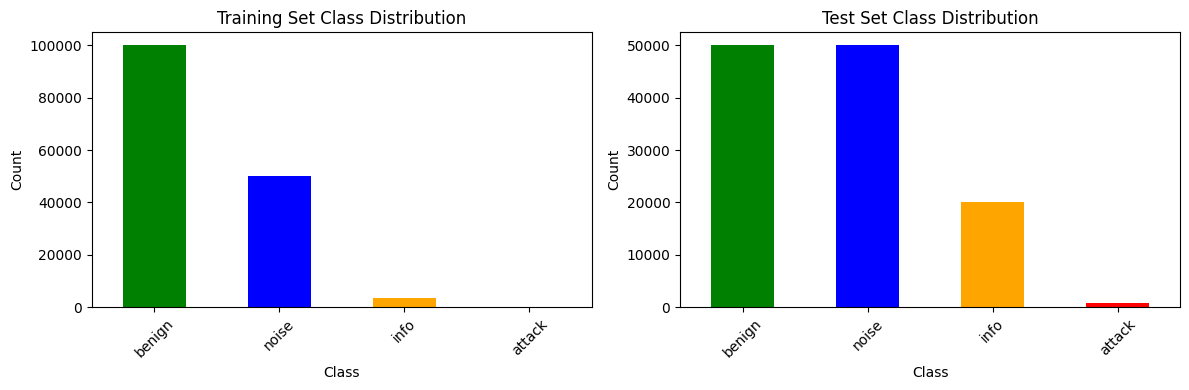

In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training
train_df['label_binary'].value_counts().plot(
    kind='bar', ax=axes[0], color=['green', 'blue', 'orange', 'red']
)
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test
test_df['label_binary'].value_counts().plot(
    kind='bar', ax=axes[1], color=['green', 'blue', 'orange', 'red']
)
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/plots/class_distribution.png', dpi=150)
plt.show()

## 3. Feature Engineering

In [6]:
# Initialize feature engineer
engineer = get_feature_engineer()

# Fit on training data and transform
X_train, feature_names = engineer.fit_transform(train_df, scale=False)

# Transform test data
X_test = engineer.transform(test_df)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nFeatures ({len(feature_names)}):")
for name in feature_names:
    print(f"  - {name}")

[2026-01-27 12:05:14,416] INFO - ============================================================
[2026-01-27 12:05:14,417] INFO - Feature Engineering v2 (Leakage-Free)
[2026-01-27 12:05:14,417] INFO - ============================================================
[2026-01-27 12:05:14,417] INFO - EXCLUDED features: severity, signature_id (data leakage)
[2026-01-27 12:05:14,418] INFO - INCLUDED features: network behavior, flow stats, timing
[2026-01-27 12:05:15,534] INFO - 
Extracted 59 features
[2026-01-27 12:05:15,534] INFO - Feature matrix shape: (153490, 59)
[2026-01-27 12:05:15,535] INFO - 
Feature categories:
[2026-01-27 12:05:15,535] INFO -   - Network/Flow: bytes, packets, ports, ratios
[2026-01-27 12:05:15,535] INFO -   - Categorical: protocol, direction, VLAN
[2026-01-27 12:05:15,536] INFO -   - IP-based: internal/external, traffic direction
[2026-01-27 12:05:15,536] INFO -   - Time-based: hour, day, business hours
[2026-01-27 12:05:15,539] INFO - Extracting features (transform mode

Training features shape: (153490, 59)
Test features shape: (120843, 59)

Features (59):
  - src_port
  - dest_port
  - bytes_toserver
  - bytes_toclient
  - pkts_toserver
  - pkts_toclient
  - bytes_total
  - pkts_total
  - bytes_ratio
  - pkts_ratio
  - bytes_bidirectional
  - avg_pkt_size_toserver
  - avg_pkt_size_toclient
  - avg_pkt_size_total
  - is_privileged_src_port
  - is_privileged_dest_port
  - is_ephemeral_src_port
  - is_high_port_dest
  - dest_is_web
  - dest_is_ssh
  - dest_is_dns
  - dest_is_mail
  - dest_is_database
  - dest_is_smb
  - dest_is_rdp
  - dest_is_proxmox
  - dest_is_opensearch
  - is_uncommon_dest_port
  - bytes_total_log
  - bytes_toserver_log
  - bytes_toclient_log
  - pkts_total_log
  - is_small_flow
  - is_large_flow
  - proto_encoded
  - proto_is_tcp
  - proto_is_udp
  - proto_is_icmp
  - direction_encoded
  - vlan
  - vlan_10
  - vlan_20
  - vlan_30
  - vlan_40
  - vlan_50
  - is_internal_src
  - is_internal_dest
  - is_private_src
  - is_private_des

In [7]:
# Get labels
y_train, label_encoder = engineer.get_labels(train_df, label_type='binary')
y_test, _ = engineer.get_labels(test_df, label_type='binary')

print(f"\nLabel classes: {label_encoder.classes_}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

[2026-01-27 12:05:16,474] INFO - 
Labels (binary):
[2026-01-27 12:05:16,475] INFO -   attack: 63
[2026-01-27 12:05:16,475] INFO -   benign: 100,000
[2026-01-27 12:05:16,476] INFO -   info: 3,427
[2026-01-27 12:05:16,476] INFO -   noise: 50,000
[2026-01-27 12:05:16,496] INFO - 
Labels (binary):
[2026-01-27 12:05:16,497] INFO -   attack: 843
[2026-01-27 12:05:16,497] INFO -   benign: 50,000
[2026-01-27 12:05:16,498] INFO -   info: 20,000
[2026-01-27 12:05:16,498] INFO -   noise: 50,000



Label classes: ['attack' 'benign' 'info' 'noise']
Training labels shape: (153490,)
Test labels shape: (120843,)


In [8]:
# Save feature engineer for deployment
engineer.save('../models/feature_engineer.pkl')

[2026-01-27 12:05:16,502] INFO - Saved FeatureEngineer to ../models/feature_engineer.pkl


## 4. Model Training

We train XGBoost with:
- Automatic class weight balancing (`scale_pos_weight`)
- Early stopping to prevent overfitting
- PR-AUC as primary metric (appropriate for imbalanced data)

In [9]:
# For binary classification, we need to convert to binary labels
# attack = 1, everything else = 0

# Get the attack class index
attack_idx = np.where(label_encoder.classes_ == 'attack')[0]
if len(attack_idx) > 0:
    attack_idx = attack_idx[0]
    y_train_binary = (y_train == attack_idx).astype(int)
    y_test_binary = (y_test == attack_idx).astype(int)
else:
    # If no 'attack' class, use original labels
    y_train_binary = y_train
    y_test_binary = y_test

print(f"Binary training labels: {np.bincount(y_train_binary)}")
print(f"Binary test labels: {np.bincount(y_test_binary)}")

Binary training labels: [153427     63]
Binary test labels: [120000    843]


In [10]:
# Split training data for validation
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_binary,
    test_size=0.15,
    stratify=y_train_binary,
    random_state=42
)

print(f"Training: {X_tr.shape[0]:,} samples")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")

Training: 130,466 samples
Validation: 23,024 samples
Test: 120,843 samples


In [11]:
# Initialize trainer and train model
trainer = get_trainer()

model = trainer.train_xgboost(
    X_tr, y_tr,
    X_val=X_val,
    y_val=y_val,
    task='binary'
)

[2026-01-27 12:05:16,643] INFO - Training XGBoost (binary)...
[2026-01-27 12:05:16,645] INFO - Computed scale_pos_weight: 2415.04


[0]	validation_0-logloss:0.64440	validation_1-logloss:0.64440
[1]	validation_0-logloss:0.60029	validation_1-logloss:0.60029
[2]	validation_0-logloss:0.56019	validation_1-logloss:0.56019
[3]	validation_0-logloss:0.52358	validation_1-logloss:0.52357
[4]	validation_0-logloss:0.49003	validation_1-logloss:0.49003
[5]	validation_0-logloss:0.45920	validation_1-logloss:0.45920
[6]	validation_0-logloss:0.43079	validation_1-logloss:0.43079
[7]	validation_0-logloss:0.40454	validation_1-logloss:0.40453
[8]	validation_0-logloss:0.38023	validation_1-logloss:0.38022
[9]	validation_0-logloss:0.35767	validation_1-logloss:0.35767
[10]	validation_0-logloss:0.33671	validation_1-logloss:0.33671
[11]	validation_0-logloss:0.31719	validation_1-logloss:0.31719
[12]	validation_0-logloss:0.29899	validation_1-logloss:0.29899
[13]	validation_0-logloss:0.28200	validation_1-logloss:0.28200
[14]	validation_0-logloss:0.26612	validation_1-logloss:0.26611
[15]	validation_0-logloss:0.25125	validation_1-logloss:0.25125
[1

[2026-01-27 12:05:18,738] INFO - XGBoost training complete


In [12]:
# Optimize classification threshold
optimal_threshold = trainer.optimize_threshold(X_val, y_val, metric='f1')

[2026-01-27 12:05:18,742] INFO - Optimizing threshold for f1...
[2026-01-27 12:05:18,954] INFO - Optimal threshold: 0.10 (f1: 1.0000)


## 5. Evaluation

In [13]:
# Evaluate on test set
metrics = trainer.evaluate(
    X_test, y_test_binary,
    threshold=optimal_threshold
)

[2026-01-27 12:05:18,957] INFO - Evaluating model...
[2026-01-27 12:05:19,045] INFO - Accuracy: 0.9947
[2026-01-27 12:05:19,045] INFO - PR-AUC: 0.6223
[2026-01-27 12:05:19,046] INFO - ROC-AUC: 0.9970
[2026-01-27 12:05:19,046] INFO - 
Classification Report:
[2026-01-27 12:05:19,063] INFO - 
Confusion Matrix:


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    120000
           1       0.57      1.00      0.72       843

    accuracy                           0.99    120843
   macro avg       0.78      0.99      0.86    120843
weighted avg       1.00      0.99      1.00    120843

[[119364    636]
 [     4    839]]


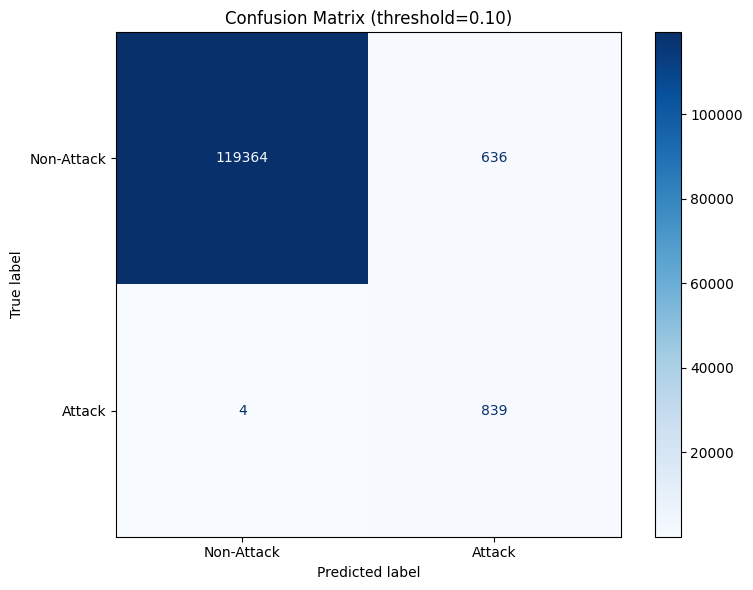

In [14]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= optimal_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_test_binary, y_pred,
    display_labels=['Non-Attack', 'Attack'],
    cmap='Blues',
    ax=ax
)
ax.set_title(f'Confusion Matrix (threshold={optimal_threshold:.2f})')

plt.tight_layout()
plt.savefig('../results/plots/confusion_matrix.png', dpi=150)
plt.show()

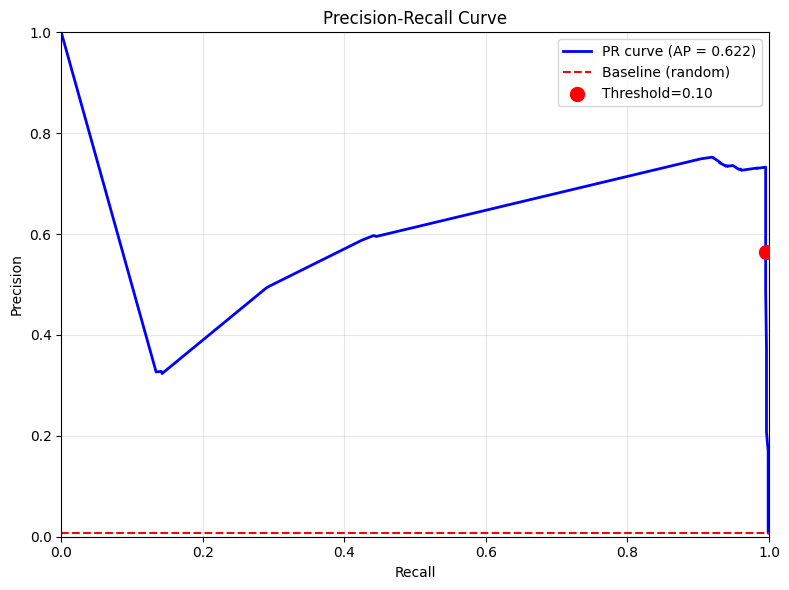

In [15]:
# Plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_binary, y_prob)
ap = average_precision_score(y_test_binary, y_prob)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall, precision, 'b-', linewidth=2, label=f'PR curve (AP = {ap:.3f})')
ax.axhline(y=y_test_binary.mean(), color='r', linestyle='--', label='Baseline (random)')

# Mark the threshold point
idx = np.argmin(np.abs(thresholds - optimal_threshold))
ax.scatter([recall[idx]], [precision[idx]], color='red', s=100, zorder=5, 
           label=f'Threshold={optimal_threshold:.2f}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc='best')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/pr_curve.png', dpi=150)
plt.show()

## 6. Feature Importance

In [16]:
# Get feature importance
importance_df = trainer.get_feature_importance(feature_names, top_n=20)

[2026-01-27 12:05:19,555] INFO - 
Top 20 Features:
[2026-01-27 12:05:19,556] INFO -   avg_pkt_size_toserver: 0.5757
[2026-01-27 12:05:19,556] INFO -   avg_pkt_size_total: 0.2485
[2026-01-27 12:05:19,557] INFO -   proto_encoded: 0.0898
[2026-01-27 12:05:19,557] INFO -   bytes_toserver: 0.0199
[2026-01-27 12:05:19,557] INFO -   pkts_toserver: 0.0146
[2026-01-27 12:05:19,558] INFO -   is_internal_traffic: 0.0132
[2026-01-27 12:05:19,558] INFO -   bytes_total: 0.0125
[2026-01-27 12:05:19,558] INFO -   bytes_total_log: 0.0116
[2026-01-27 12:05:19,559] INFO -   proto_is_udp: 0.0095
[2026-01-27 12:05:19,559] INFO -   dest_port: 0.0017
[2026-01-27 12:05:19,560] INFO -   pkts_total: 0.0015
[2026-01-27 12:05:19,560] INFO -   pkts_total_log: 0.0014
[2026-01-27 12:05:19,560] INFO -   src_port: 0.0000
[2026-01-27 12:05:19,561] INFO -   is_night: 0.0000
[2026-01-27 12:05:19,561] INFO -   is_business_hours: 0.0000
[2026-01-27 12:05:19,561] INFO -   hour_of_day: 0.0000
[2026-01-27 12:05:19,562] INFO -

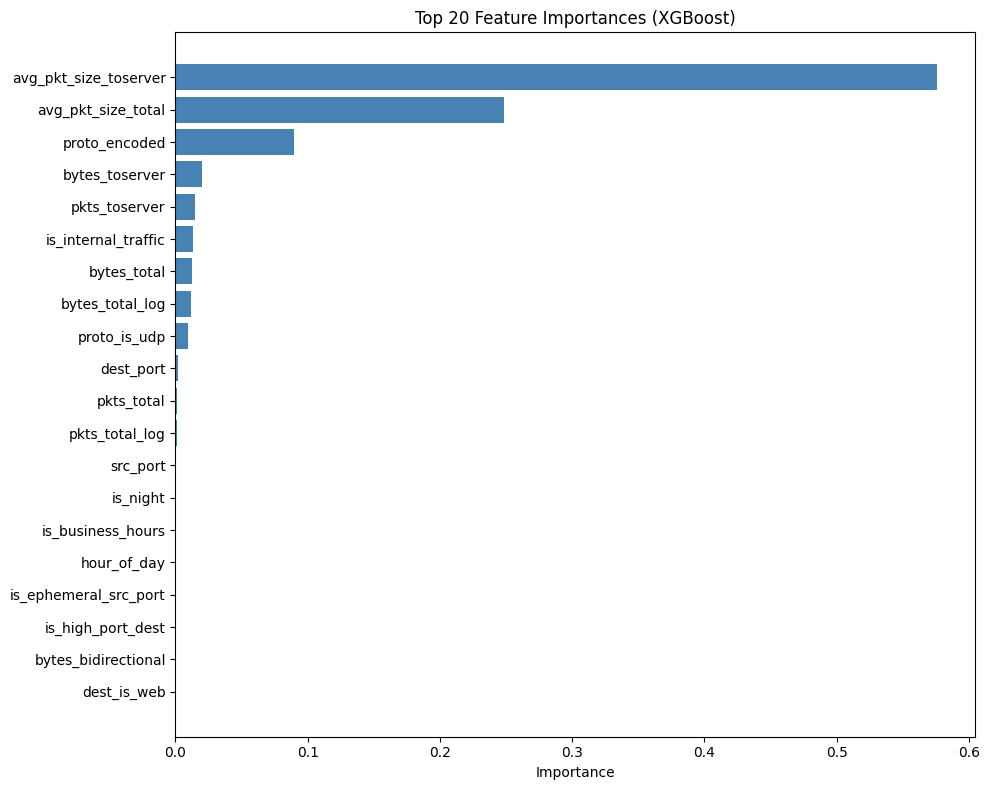

In [17]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

importance_df_sorted = importance_df.sort_values('importance', ascending=True)
ax.barh(importance_df_sorted['feature'], importance_df_sorted['importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances (XGBoost)')

plt.tight_layout()
plt.savefig('../results/plots/feature_importance.png', dpi=150)
plt.show()

## 7. SHAP Analysis

In [18]:
import shap

# Create explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values on a sample (full dataset is slow)
sample_size = min(5000, len(X_test))
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_idx]

shap_values = explainer.shap_values(X_sample)
print(f"SHAP values computed for {sample_size} samples")

SHAP values computed for 5000 samples


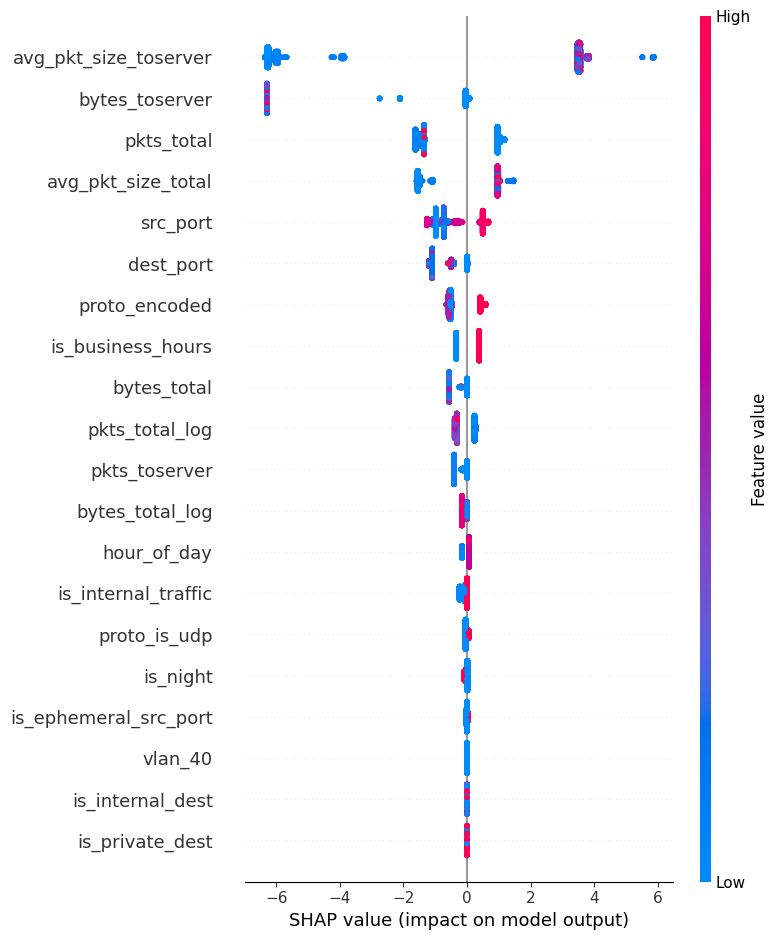

In [19]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('../results/plots/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

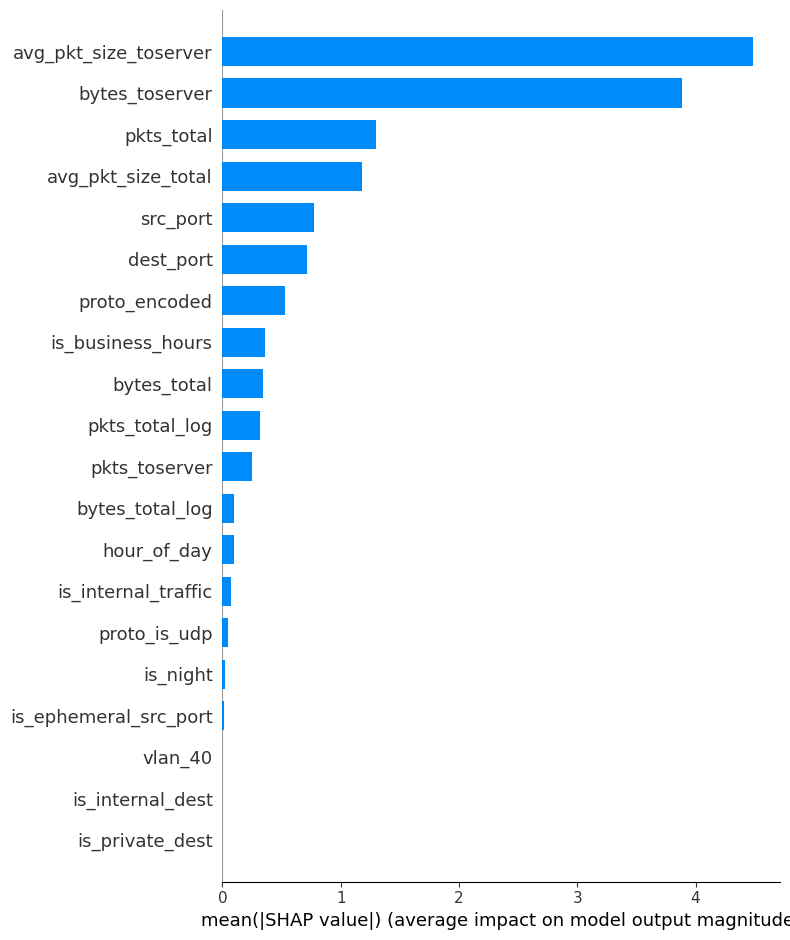

In [20]:
# SHAP Bar Plot (mean absolute importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                  plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('../results/plots/shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Model

In [21]:
# Create timestamped model directory
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_dir = f'../models/xgboost_binary_{timestamp}'

# Save model with metadata
trainer.save_model(
    model_dir,
    feature_names=feature_names,
    metrics=metrics
)

print(f"\nModel saved to: {model_dir}")

[2026-01-27 12:05:22,264] INFO - Model saved to ../models/xgboost_binary_20260127_120522
[2026-01-27 12:05:22,265] INFO -   - Model: ../models/xgboost_binary_20260127_120522/model.json
[2026-01-27 12:05:22,266] INFO -   - Metadata: ../models/xgboost_binary_20260127_120522/metadata.json



Model saved to: ../models/xgboost_binary_20260127_120522


In [22]:
# Save metrics report
import json

report = {
    'model': 'XGBoost Binary Classifier',
    'task': 'Threat Detection',
    'training_date': timestamp,
    'data': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': len(feature_names)
    },
    'metrics': {
        'pr_auc': metrics.get('pr_auc'),
        'roc_auc': metrics.get('roc_auc'),
        'accuracy': metrics.get('accuracy'),
        'threshold': optimal_threshold
    },
    'top_features': importance_df.head(10).to_dict('records')
}

with open('../results/reports/training_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("Training report saved!")

Training report saved!


## 9. Summary

### Results

| Metric | Value |
|--------|-------|
| PR-AUC | See above |
| ROC-AUC | See above |
| Optimal Threshold | See above |
| Accuracy | See above |

### Key Findings

1. **Top predictive features:** (see feature importance plot)
2. **Class separation:** The model successfully distinguishes attacks from noise
3. **Threshold selection:** Optimized for F1 to balance precision and recall

### Next Steps

1. Deploy model to SOC automation pipeline
2. Implement real-time scoring
3. Create feedback loop for model improvement
4. Train multiclass model for attack type classification

In [23]:
print("="*60)
print("  SOC-ML Training Complete!")
print("="*60)
print(f"\nModel: XGBoost Binary Classifier")
print(f"PR-AUC: {metrics.get('pr_auc', 'N/A'):.4f}")
print(f"Threshold: {optimal_threshold:.2f}")
print(f"\nSaved to: {model_dir}")

  SOC-ML Training Complete!

Model: XGBoost Binary Classifier
PR-AUC: 0.6223
Threshold: 0.10

Saved to: ../models/xgboost_binary_20260127_120522
